# Spine Model


In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
import PS_tools as tools

from bootstrap import btset_cd, generateplots, btShInh


# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
#data.dt = 0.05
#data.NMDA = False


# Definition of the model.

#NMDA = data.NMDA
model = lb.loadNeuron("ball-2sticks.hoc",axon=False)
data.model = model.__dict__
lb.h.dt = data.model['dt']

# Adding piece of dendritic branch with spine
model.addDend(name="dendShaft",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="dendShaft",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="dendA2",locus=3,L=240.0,D=0.5,ilocus=1)

model.soma.L = 20
model.dend[-1].L = 200
model.dend[-1].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())


	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 6283.185307179586
Topology:

|-|       soma(0-1)
   `|       dendA1prox(0-1)
     `|       dendA1(0-1)
       `|       dendShaft(0-1)
         `|       dendA2(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


### Bootstrapping spines



In [2]:
nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']#*2
sis['Rneck'] = sis['Rneck']#*2
sps['Rneck'] = sps['Rneck']#*2
#generateplots(dis,corplot=True)


sp = model.spne[0]
sp.L = dis["L"].mean()
sp.diam = dis["D"].mean()

print("Area Volume Ah Vh")
print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0]/dis["AhA0"][0],dis["Vh"][0])

Area Volume Ah Vh
1.5100459972916676 0.27509650792072304 0.8434003423265786 0.10019824399440201


In [3]:
#nsp = 1000
#figure()
iPSDsh = btShInh(size=nsp)
#h = hist(iPSDsh,31)
#xlabel("iPSD shaft ($\mu m^2$)",fontsize=14)


In [4]:

rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2

gtrG = rhGABAR*30e-6*0.4
gtrA = rhAMPAR*11e-6*0.6
gtrN = rhNMDAR*30e-6*3.075787


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [5]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = 0.5
tau2 = 1.8
AMPA.tau1 = tau1
AMPA.tau2 = tau2

gmax = gtrG*sps['A1'].mean()
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
nnmda = 2
gmaxN = gtrN*sps['A1'].mean()
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = 5.0
NMDA.tau2 = 15.0


### Inhibitory synapse

In [9]:
gmaxG = gtrG*dis['A2'].mean()
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=1.5,tau2=15.0)  


gmaxG = gtrG*iPSDsh.mean()
GABA2, NCG2 = lb.add_GABAsynscomp(model, model.comp['dendShaft'], loc = 0.1, gmax=gmaxG,tau1=1.5,tau2=15.0)  



# Recordings

In [10]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 


Vector[16]

In [102]:
model.dend

[dendA1prox, dendA1, dendB1, dendShaft, dendA2]

In [11]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [12]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [13]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]

currentGABA = iRec[1]
iRec.append(lb.h.Vector())
currentNMDA = iRec[-1]
currentNMDA.record(NMDA._ref_i)


Vector[39]

In [14]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[38]

In [65]:
iRec.append(lb.h.Vector())
currentGABA2 = iRec[-1]
currentGABA2.record(GABA2._ref_i)


Vector[40]

## Small tuning parameters for dendrite?

In [103]:
dendsizeL0 = 10
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),150)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = dendsizeL0
dend.diam = 1.0
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dendc = model.dend[1]
dendc.L = dendsizeL
dend.diam = 0.87
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-2]
dend.diam = 0.87
dendsh = model.dend[-2]
dend.L = 1
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck/1e6,Rdend/1e6))

10.0 1.0
175.32514088551122 0.8700000047683717 31.830988618379067
1.0 0.87 400.49081837576085
The resistance of neck and the dendritic impedance are 174.32 and 403 MΩ (resp.)


In [104]:
#model.soma.diam = model.soma.L
dendN = model.dend[-1]
dendN.L = 1

In [105]:
dendsh.diam = 0.870
dendc.diam = 0.870
dendN.diam = 0.870        

In [106]:
rhosp = 1.3
diamneck = sps['meanDneck'].mean()/1e3
dendareaperL = rhosp*(mean(sps['Ah'])+(pi*diamneck))
factor = dendareaperL/(pi*dendc.diam)
print(factor)
factorsp = factor
factordd = (pi*dendc.diam-(pi*diamneck**2/4.0)*rhosp)/(pi*dendc.diam)
print(factordd,factordd+factorsp)

factor = factordd+factorsp
factor = 3.7

dendN.cm = factor
dendc.cm = factor

dendN.g_pas = factor/model.RM
dendc.g_pas = factor/model.RM

2.7286184943581073
0.9764176271098868 3.705036121467994


In [107]:
dendc.nseg = int(dendc.L//10)+1
dendN.nseg = int(dendN.L//10)+1

dendc.nseg = 10
dendN.nseg = 10
print(dendc.nseg,dendN.nseg)

10 10


In [108]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

In [109]:
diam0 = 0.15
#Rneck0 = Rneck/1e6
#Cm0 = model.CM


In [110]:
Rneck0 = neck.Ra*sps['Lneck']/(diam0)**2*0.04/pi
#print(Rneck0,data[i,3])
#diams = diam0*sqrt(Rneck0/sps['Rneck'])
#hist(diams, 51,density = True)
#hist(sps['minDneck']/1e3,51,alpha=0.7,density = True)
#hist(sps['meanDneck']/1e3,51,alpha=0.7,density = True)

In [66]:
def simulateSet(model,spn,tG = 500,ton = 50,
                toffset = 50,t_stop = 250, EL = -65,
                btsr = None,VDCC = array([0.,0,0,0]), 
                dendrec = True,inhOutside= False):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck = model.neck[0]
    sp = model.spne[0]
    sp.Ra = 500
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"], spn["meanDneck"]/1e3))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
         
    nsp = data.shape[0]
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        NCG2.weight[0] = iPSDsh[i] *gtrG#*0

        if inhOutside:
            NCG.weight[0] = 0.0
        else:
            NCG2.weight[0] = 0.0
            
            
        neck.L = data[i,7]  
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        # neck.diam = data[i,9]
        # Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
        # neck.Ra = data[i,3]*(neck.diam)**2*pi/0.04/neck.L
        
        posD = data[i,4]
        
        dendc.L = posD-dshL/2
        dendN.L = dendsizeL-posD-dshL/2

        
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        sp.g_pas = data[i,8]/model.RM
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50
        NCG2.delay = toffset+tG#toffset+tG#-50

        for il in range(10):
            f = 1-7.5*il/dendc.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendc(f)._ref_v)
            else:
                vDendEL[il].record(dendc(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendc.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendN(f)._ref_v)
            else:
                vDendEL2[il].record(dendN(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)
        
        

                    
        #print(data[i,:])
        lb.neuron.run(t_stop)
        
        #plot(trec,vspneRec[0])    
        
        current = abs((array(vDendRec[1])-array(vrec[0]))/Rdend)
        
        vtracs[:,i] = array(vspneRec[0]) 
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])
            
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        if inhOutside:
            aG = abs(array(currentGABA2)).argmax()
            maxGABA = array(currentGABA2)[aG]
        else:
            aG = abs(array(currentGABA)).argmax()
            maxGABA = array(currentGABA)[aG]

            
        #aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        aN = abs(array(currentNMDA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,
                    max(vDendRec[3])-EL,max(vrec)-EL,
                    max(cat)-cat[0],maxGABA,
                    array(currentAMPA)[aA],spvol,
                    array(currentNMDA)[aN]]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,array(trec))

In [24]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

In [25]:
#vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa, dendrec=False)
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])

In [26]:
from PS_tools import *

In [27]:
from bootstrap import dataset,datasetfile
with open(datasetfile,"rb") as f:
    data = pickle.load(f)
spdata = dataset(data,noise=0.0)
spdata['A2'][isnan(spdata['A2'])] = 0.0
#spdata['Rneck'] = spdata['Rneck']

sel = ones(spdata['A2'].shape[0]) == 1
keys = list(spdata.keys())
keys.pop(12)
keys.pop(11)
keys.pop(7)
keys.pop(3)

for key in keys:
    sel = sel*isfinite(spdata[key])
    
for key in spdata.keys():
    spdata[key] = spdata[key][sel]
    #print(key,':',isfinite(spdata[key]).sum())

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [28]:
gtrA0 = gtrA

In [29]:
model.comp['soma'].diam,model.comp['soma'].L

(29.78380012512207, 20.0)

In [30]:
model.RM = 15e3
AMPA.tau1 = 0.10
AMPA.tau2 = 0.7

In [31]:
dendA2 = model.comp['dendA2']
dendA1 = model.comp['dendA1']

In [32]:
gtrA = gtrA0*49.5/49

for sec in lb.h.allsec():
    sec.Ra = 250
    sec.cm = 1.0
    sec.g_pas = 1.0/model.RM

factor = 1
model.comp['dendB1'].cm = factor
model.comp['dendB1'].g_pas = factor/model.RM
model.comp['dendB1'].L = 30
model.comp['dendB1'].diam = 1

extra = 3.7
dendA2.cm = extra
dendA1.cm = extra

dendA2.g_pas = extra/model.RM
dendA1.g_pas = extra/model.RM

In [33]:
((model.comp['dendB1'].cm*1e-6)/(model.comp['dendB1'].g_pas)/1e-3)


15.0

In [34]:
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
#with open("../SpineModel/All_baseline_datasetx2.pickle","wb") as f:
#    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,spdata],f) 
 

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in sqrt


Spines <uEPSC> = 57.79, (med,cf int 0.68) = (40.81,16.51,109.57)
DiS <uEPSC> = 91.65, (med,cf int 0.68) = (83.35,43.83,156.32)
<uEPSP> = 0.90, (med,cf int 0.68) = (0.64,0.26,1.66)
CV and conductance 0.8672143132521911 0.9549289548232951


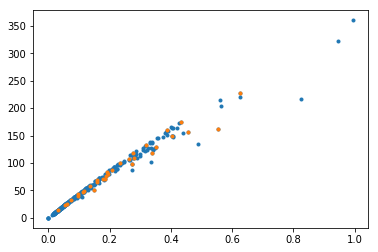

In [35]:
plot(spdata['A1'],-mes[:,-3]*1000,'.')
sel = spdata['nPSD']==2.0
plot(spdata['A1'][sel],-mes[sel,-3]*1000,'.')
i = getintp(-mes[:,-3]*1000,0.68)
print('Spines <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[:,-3].mean()*1e3,i[0],i[1],i[2]))
i = getintp(-mes[sel,-3]*1000,0.68)
print('DiS <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[sel,-3].mean()*1e3,i[0],i[1],i[2]))

i = getintp(mes[:,3],0.68)
print('<uEPSP> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (mes[:,3].mean(),i[0],i[1],i[2]))
print('CV and conductance', mes[:,3].std()/mes[:,3].mean(), spdata['A1'].mean()*gtrA*1e3)

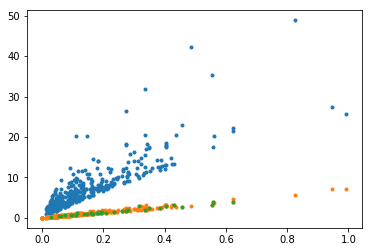

In [116]:
plot(spdata['A1'],mes[:,3],'.')
plot(spdata['A1'][sel],mes[sel,3],'.')


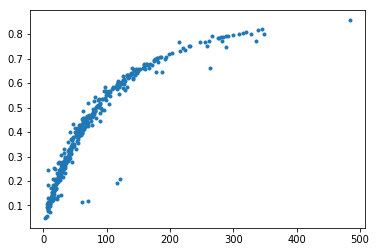

In [119]:
plot(spdata['Rneck'],(mes[:,1]-mes[:,2])/mes[:,1],'.')


(118, 140)

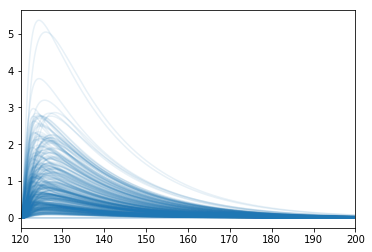

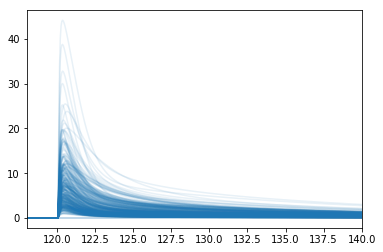

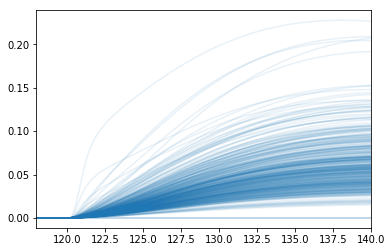

In [37]:
trec = 0.05*arange(vtracsS.shape[0])
for i in range(vtracsS.shape[1]):
    plot(trec,vtracsS[:,i]+70,'C0',alpha=0.1)
xlim(2400*.05,4000*.05)

figure()
trec = 0.05*arange(vtracsS.shape[0])
for i in range(vtracsS.shape[1]):
    plot(trec,vtracs[:,i]+70,'C0',alpha=0.1)
xlim(118,140)

figure()
trec = 0.05*arange(vtracsS.shape[0])
for i in range(vtracsS.shape[1]):
    plot(trec,Ctracs[:,i],'C0',alpha=0.1)
xlim(118,140)

(2.081436314363144, 16.893020590571783, 19.30158363591618, 4.644842614064123)

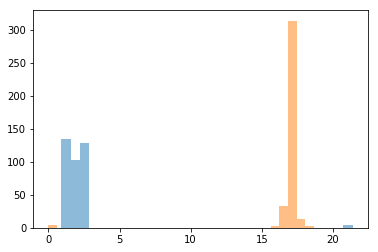

In [39]:
tFWHM = tools.get_FWHMtimes(vtracsS,-70)
ts,_,trise = tools.get_atimes(vtracsS+70,ton=2400)
tssp,_,_ = tools.get_atimes(vtracs+70,ton=2400)
#ts,_,trise = get_atimes(vtracsS+70,ton=2400)
t2080 = tools.get_p0p1times(vtracsS)#
t8020 = get_postp0p1times(vtracsS)#

#print(ts)
#h0 = hist(tFWHM,31)
#h1 = hist(ts[:,0],31,alpha=0.5)
h1 = hist(t2080,31,alpha=0.5)
h1 = hist(t8020/log(4),31,alpha=0.5)

t2080.mean(),t8020.mean()/log(4),ts[:,0].mean(),tssp.mean()

In [40]:
gtrAp = gtrA0*49.5/49


In [41]:
gtrAp/rhAMPAR/11e-6

0.6061224489795918

In [42]:
NMDA.tau1 = .5
NMDA.tau2 = 17

In [43]:
gtrN0 = gtrN

In [41]:
gtrA = gtrAp*0
gtrN = rhNMDAR*30e-6*10.23975
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = 30,btsr = ones(9)==1,
                  VDCC = VDCCa*0,dendrec=False)
vavg0,mes0,vtracs0,vtracsD,vtracsS,Ctracs,me2,me3,_ = res
print(mes[:,-2].mean())

0.19174143609180733


In [42]:
print(mes0[:,4].mean(),mes0[:,-1].mean())

3.1846968516354828 0.010252998968095907


In [40]:
spdata['A1'].mean()*gtrN,spdata['A1'].mean()*gtrAp

(0.0006185504520581919, 0.001043405560351132)

In [44]:
gtrA = gtrAp
gtrN = gtrN0*0
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCa*0,dendrec=False)
vavg0,mes0,vtracs0,vtracsD,vtracsS,Ctracs,me2,me3,_ = res


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in sqrt


In [45]:
gtrA = gtrAp
gtrN =  rhNMDAR*30e-6*10.23975*2#gtrN0*15/3.24
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCa*0,dendrec=False)
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in sqrt


In [46]:
ratio = ((mes[:,-1]+mes[:,-3])/mes0[:,-3]-1)
nanmean(ratio)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.02857197821885121

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


0.029478621672796912 nan 0.33569864532867966


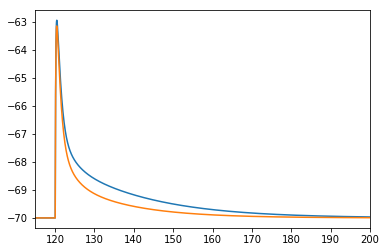

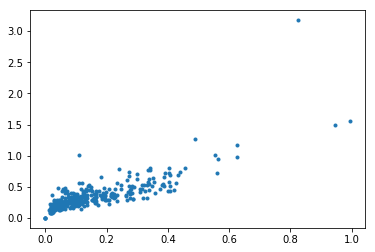

In [47]:
plot(arange(vtracs.shape[0])*0.05,vtracs.mean(1),'-')
plot(arange(vtracs.shape[0])*0.05,vtracs0.mean(1),'-')
xlim(115,200)
figure()
plot(spdata['A1'],mes[:,4],'.')
print(mes[:,1].mean()/mes0[:,1].mean()-1.0,((mes[:,-1]+mes[:,-3])/mes0[:,-3]-1).mean(),mes[:,4].mean())

In [48]:
gtrNp = gtrN
print(gtrAp/rhAMPAR/10e-6,gtrNp/rhNMDAR/30e-6)

0.6667346938775508 20.4795


In [49]:
sel = isnan(spdata['A2'])
spdata['A2'][sel] = 0

In [50]:
spdata['A2'][spdata['A2']>0].mean()/iPSDsh.mean()

0.5412934978607085

In [51]:
2.6183844*.554969455


1.453123363448502

In [52]:
GABA.tau1 = 0.5
#AMPA.tau2 = 1.3

In [53]:
gtrG0 = gtrG

In [54]:
gtrG0

0.006000000000000001

In [55]:
seldis = spdata['A2']>0
#plot(spdata['A2'][seldis],mes1[seldis,0]/mes[seldis,0])
#plot(spdata['A2'][seldis],mes1[seldis,4]/mes[seldis,4],'.')
#(mes1[seldis,4]/mes[seldis,4]).mean()

NameError: name 'mes1' is not defined

In [59]:
iPSDsh = btShInh(size=len(spdata['A1']))


In [60]:
Rn0 = spdata['Rneck']
A20 = spdata['A2']

In [61]:
iPSDsh.mean()/A20[A20>0].mean()

1.8291765905955528

In [71]:
gtrA = 0.0
gtrN = 0.0
gtrG = gtrG0*1.45*2.3
#spdata['Rneck'] = Rn0*1e-3
#spdata['A2'] = A20*1.87

res = simulateSet(model,spdata,tG = 10,ton = 50,toffset = 70,
                  t_stop = 500, EL = 0.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = True)

vavg1,mes1,vtracs1,vtracsD1,vtracsS1,Ctracs1,me2,me3,_ = res
#spdata['Rneck'] = Rn0
#spdata['A2'] = A20

In [72]:
print(mes1[:,-4].mean())
gtrGp = gtrG0*1.45*2.3

0.14270915150044558


In [73]:
print(gtrAp/rhAMPAR/10e-6,gtrNp/rhNMDAR/30e-6,gtrGp/rhGABAR/30e-6)

0.6667346938775508 20.4795 1.3339999999999999


In [121]:
print(gtrAp,gtrNp,gtrGp)

0.006667346938775509 0.006143850000000001 0.02001


In [100]:
print(AMPA.tau1,AMPA.tau2,GABA.tau1,GABA.tau2,NMDA.tau1,NMDA.tau2)

0.1 0.7 0.5 15.0 0.5 17.0


In [ ]:
gtrA = 0.0
gtrN = 0.0
gtrG = gtrG0*1.45*2.3
#spdata['Rneck'] = Rn0*1e-3
#spdata['A2'] = A20*1.87

res = simulateSet(model,spdata,tG = 10,ton = 50,toffset = 70,
                  t_stop = 500, EL = -60.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = True)

vavg1,mes1,vtracs1,vtracsD1,vtracsS1,Ctracs1,me2,me3,_ = res

(120, 250)

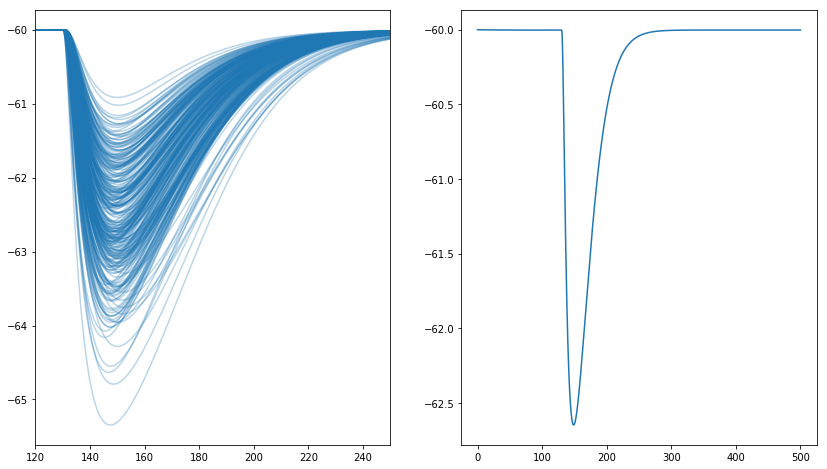

In [79]:
fig,ax = subplots(1,2,figsize=(14,8))
for i in range(300):
    ax[0].plot(trec,vtracsS1[:,i],'C0-',alpha=0.3)
ax[1].plot(trec,vtracsS1[:,:].mean(1),'-')
ax[0].set_xlim(120,250)

In [83]:
gtrA = gtrAp
gtrN = gtrNp
gtrG = gtrG0*1.45*2.3
res = simulateSet(model,spdata,tG = 500,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = False)

vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt


In [81]:

#spdata['Rneck'] = Rn0*1e-3
#spdata['A2'] = A20*1.87

res = simulateSet(model,spdata,tG = -2,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = False)

vavgD,mesD,vtracsD,vtracsDD,vtracsSD,CtracsD,me2,me3,_ = res


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt


In [87]:
spdata.keys()

dict_keys(['#Bch', 'Dsb', 'Dss', 'd_interSp', 'Vtot', 'Vh', 'Ln', 'SA', 'nPSD', 'A1', 'A2', 'GPHN SNR', 'DiS-EMchk', 'Lneck', 'maxDneck', 'minDneck', 'meanDneck', 'Rneck', 'Lhead', 'maxDhead', 'minDhead', 'meanDhead', 'Ah', 'Rhead', 'L', 'D', 'AhA0'])

0.8237122606231821 0.8970005068449598


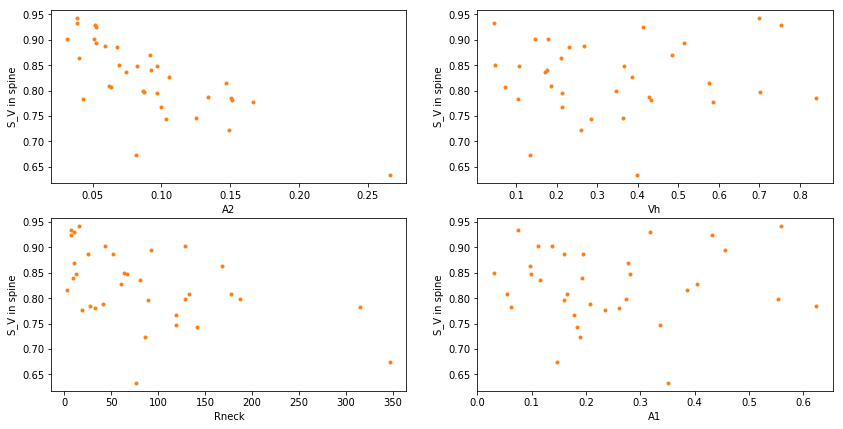

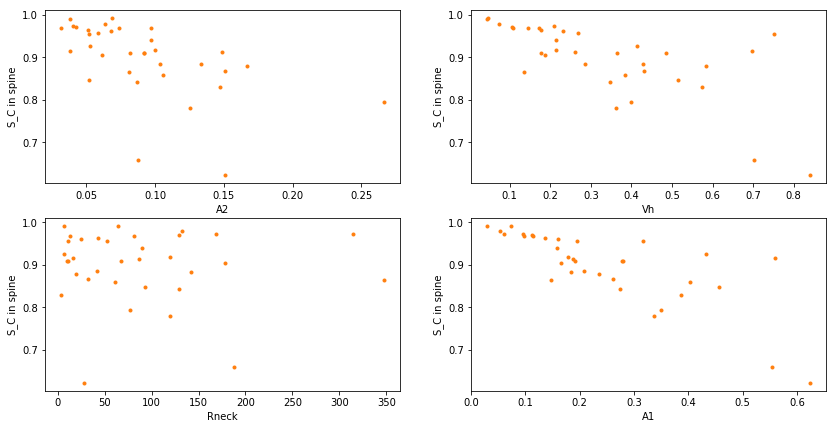

In [90]:
sel = spdata['A2']>0 
labels = ['A2','Rneck','Vh','A1']
fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    ax[i%2,i//2].plot(spdata[labels[i]][sel],mesD[sel,1]/mes[sel,1],'C1.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_V in spine')

fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    ax[i%2,i//2].plot(spdata[labels[i]][sel],mesD[sel,4]/mes[sel,4],'C1.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_C in spine')
      
print((mesD[sel,1]/mes[sel,1]).mean(),(mesD[sel,4]/mes[sel,4]).mean())

In [89]:
res = simulateSet(model,spdata,tG = -2,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = True)

vavgO,mesO,vtracsO,vtracsDO,vtracsSO,CtracsO,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt


In [98]:
iPSDsh.shape, sel0.shape

((369,), (369,))

0.8237122606231821 0.8970005068449598
0.9286143534166086 0.9414690326958471


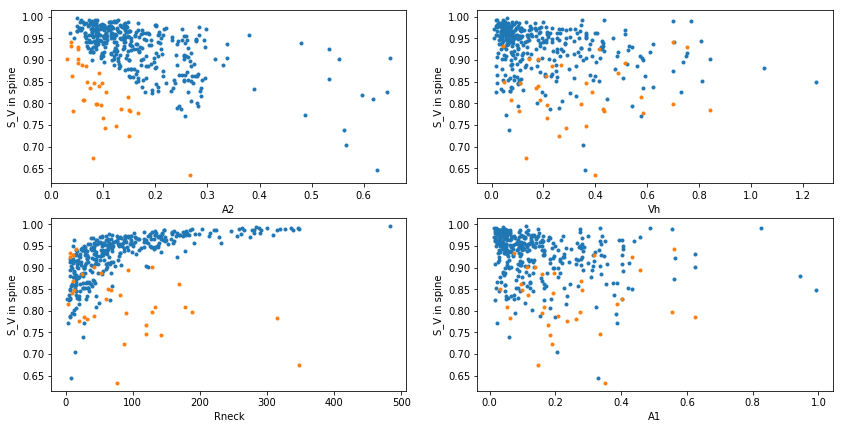

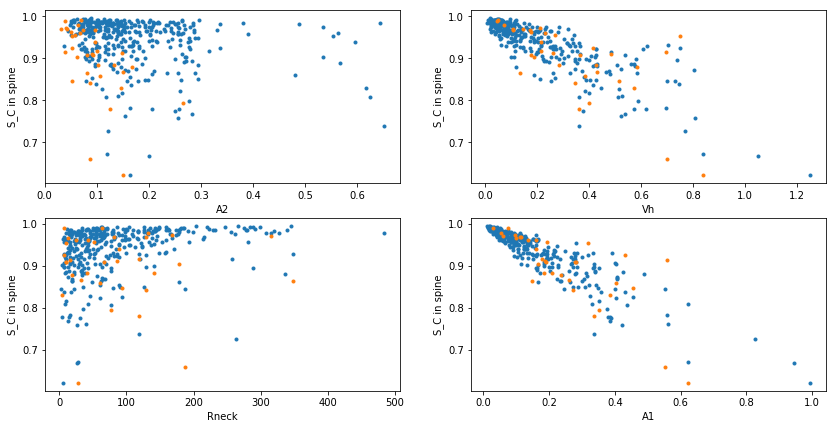

In [99]:
sel = spdata['A2']>0 
sel0 = spdata['A1']>0 

labels = ['A2','Rneck','Vh','A1']
fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    if labels[i] == 'A2':
        ax[i%2,i//2].plot(array(iPSDsh)[sel0],mesO[sel0,1]/mes[sel0,1],'.')
    else:
        ax[i%2,i//2].plot(spdata[labels[i]][sel0],mesO[sel0,1]/mes[sel0,1],'.')
    ax[i%2,i//2].plot(spdata[labels[i]][sel],mesD[sel,1]/mes[sel,1],'.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_V in spine')

fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    if labels[i] == 'A2':
        ax[i%2,i//2].plot(array(iPSDsh)[sel0],mesO[sel0,4]/mes[sel0,4],'.')
    else:
        ax[i%2,i//2].plot(spdata[labels[i]][sel0],mesO[sel0,4]/mes[sel0,4],'.')
        
    ax[i%2,i//2].plot(spdata[labels[i]][sel],mesD[sel,4]/mes[sel,4],'.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_C in spine')
      
print((mesD[sel,1]/mes[sel,1]).mean(),(mesD[sel,4]/mes[sel,4]).mean())
print((mesO[sel0,1]/mes[sel0,1]).mean(),(mesO[sel0,4]/mes[sel0,4]).mean())

In [76]:
gtrA = gtrA0*62.5/49
gtrN = gtrN0*0
VDCCn = VDCCa*0.02/.15

res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCn,dendrec=False)
vavg0,mes0,vtracs0,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

gtrA = gtrA0*62.5/49
gtrN = gtrN0*15/3.24
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCn,dendrec=False)
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in sqrt


0.0009440837500178833 0.0007309355988084202
0.0009440837500178833 0.0007309355988084202


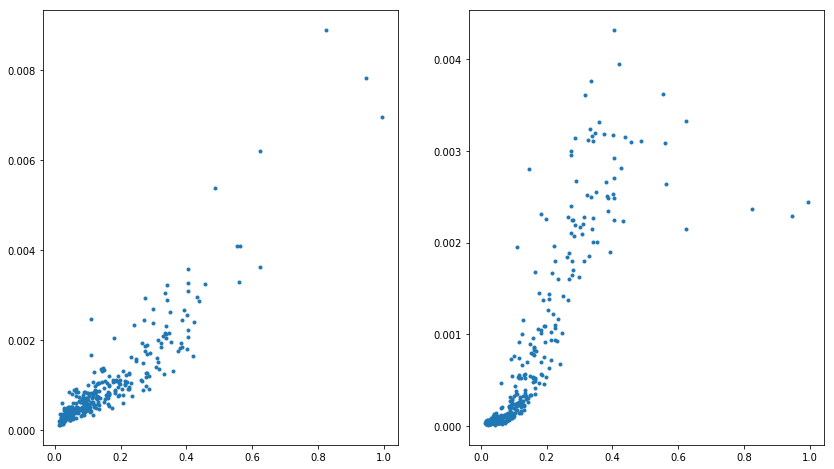

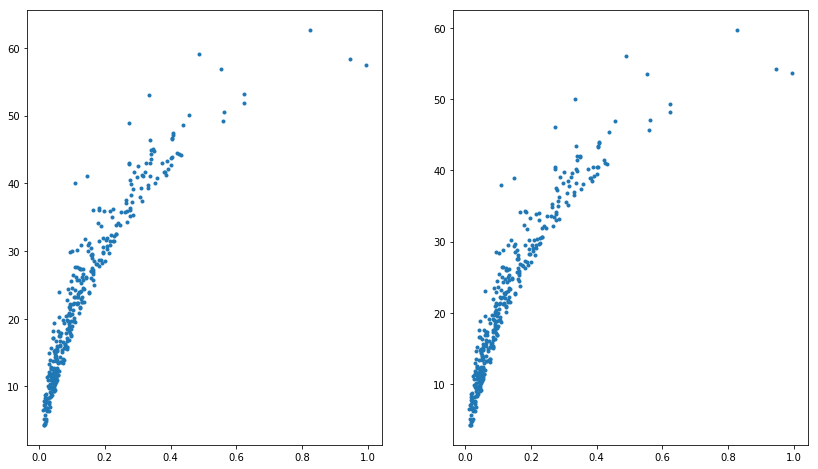

In [79]:
fig,ax = subplots(1,2,figsize=(14,8))
ax[0].plot(spdata['A1'],mes[:,4],'.')
ax[1].plot(spdata['A1'],mes0[:,4]/mes[:,4],'.')
print(mes[:,4].mean(),(mes0[:,4]/mes[:,4]).mean())
fig,ax = subplots(1,2,figsize=(14,8))
ax[0].plot(spdata['A1'],mes[:,1],'.')
ax[1].plot(spdata['A1'],mes0[:,1],'.')
print(mes[:,4].mean(),(mes0[:,4]/mes[:,4]).mean())

In [38]:
spdata['A1'].mean()*gtrN*1e3,spdata['A1'].mean()*gtrA0*1e3

(0.6185506531614066, 0.9556424758356162)

In [137]:
mes.std(axis=0)/mes.mean(axspis=0)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 0.91217706,  0.64115552,  0.75075116,  0.77743231,  0.85924093,
               nan, -0.76072381,  0.98443153,  0.75119402])

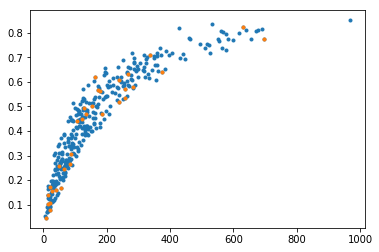

In [140]:
plot(spdata['Rneck'],(mes[:,1]-mes[:,2])/mes[:,1],'.')
sel = spdata['nPSD']==2.0
plot(spdata['Rneck'][sel],(mes[sel,1]-mes[sel,2])/mes[sel,1],'.')

In [107]:
gtrA = gtrAp
gtrN = gtrNp
AMPA.tau2 = 1.3
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False)
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in sqrt


Spines <uEPSC> = 56.92, (med,cf int 0.68) = (42.00,17.26,102.39)
DiS <uEPSC> = 86.65, (med,cf int 0.68) = (85.08,44.02,135.61)
SiS <uEPSP> = 1.70, (med,cf int 0.68) = (1.15,0.48,2.99)
CV and conductance 0.871895979615402 1.043405560351132


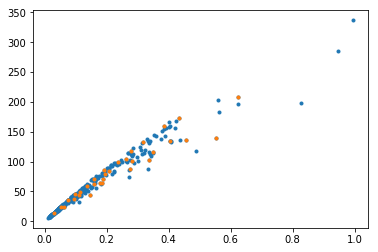

In [108]:
plot(spdata['A1'],-mes[:,-3]*1000,'.')
sel = spdata['nPSD']==2.0
plot(spdata['A1'][sel],-mes[sel,-3]*1000,'.')
i = getintp(-mes[:,-3]*1000,0.68)
print('Spines <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[:,-3].mean()*1e3,i[0],i[1],i[2]))
i = getintp(-mes[sel,-3]*1000,0.68)
print('DiS <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[sel,-3].mean()*1e3,i[0],i[1],i[2]))

i = getintp(mes[~sel,3],0.68)
print('SiS <uEPSP> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (mes[:,3].mean(),i[0],i[1],i[2]))
print('CV and conductance', mes[:,3].std()/mes[:,3].mean(), spdata['A1'].mean()*gtrA*1e3)

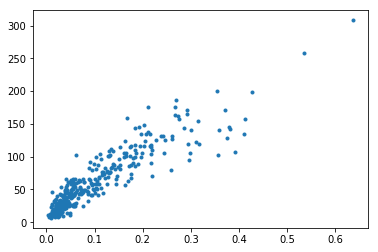

In [107]:
plot(spdata['Vh'],-mes[:,-3]*1000,'.')

In [37]:
tdels = [-49,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50]
dtime = zeros((len(tdels),15))
data = zeros((len(tdels),20))
data2 = zeros((len(tdels),20))

times_biexp = False

EL0 = -70
vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

vtt = clip(vtracs0-EL0,0,100)
if times_biexp:
    times0 = get_atimes(vtt,ton=3000, dt = lb.h.dt)
else:
    times0, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)


for i,td in enumerate(tdels):
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
    
    # EPSP in spine head
    vtt = clip(vtracs-EL0,0,100)
    if times_biexp:
        times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    else:
        times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
        times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

    #dtime[i,:2] = (times.mean(),times.std())
    dtime[i,:5] = getint(times/times0)
    #dtime[i,2:6] = (tt.mean(),tt.std(),trise.mean(),trise.std())

    # EPSP In the soma
    vtt = clip(vtracsS-EL0,0,100)
    if times_biexp:
        times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    else:
        times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
        times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

    #dtime[i,6:8] = (times.mean(),times.std())
    dtime[i,5:10] = getint(times/times0)
    
    # For calcium in spine
    vtt = clip(Ctracs,0,100)
    if times_biexp:
        times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    else:
        times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
        times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    #dtime[i,8:10] = (times.mean(),times.std())
    dtime[i,10:15] = getint(times/times0)
    
    # Statistics
    #data[i,:] = mes.mean(axis=0)
    #datt0 = mes[:,1:5]/mes0[:,1:5]
    #data2[i,:] = concatenate((datt0.mean(axis=0),datt0.std(axis=0)))
    for j in range(1,5):
        data[i,(5*(j-1)):(5*(j))] = getint(mes[:,j])
        data2[i,(5*(j-1)):(5*(j))] = getint(mes[:,j]/mes0[:,j])

In [38]:
mes0.shape

(1000, 9)

In [39]:
with open("inhibition_disx2.pickle","wb") as f:
    pickle.dump([tdels,data2,data,dtime],f)

In [40]:
td = -5
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)


(array([  1.,   0.,   4.,   6.,   5.,   9.,  13.,  15.,  19.,  15.,  17.,
         19.,  16.,  13.,  12.,  18.,  13.,  24.,  29.,  45.,  51.,  40.,
         50.,  46.,  40.,  36.,  38.,  75., 182., 100.,  49.]),
 array([0.68696994, 0.69694569, 0.70692143, 0.71689718, 0.72687292,
        0.73684867, 0.74682441, 0.75680016, 0.7667759 , 0.77675164,
        0.78672739, 0.79670313, 0.80667888, 0.81665462, 0.82663037,
        0.83660611, 0.84658186, 0.8565576 , 0.86653335, 0.87650909,
        0.88648483, 0.89646058, 0.90643632, 0.91641207, 0.92638781,
        0.93636356, 0.9463393 , 0.95631505, 0.96629079, 0.97626653,
        0.98624228, 0.99621802]),
 <a list of 31 Patch objects>)

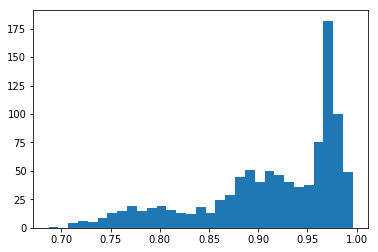

In [41]:
hist(mes[:,4]/mes0[:,4],31)

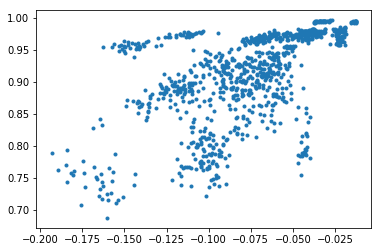

In [42]:
plot(mes[:,-3],mes[:,4]/mes0[:,4],'.')

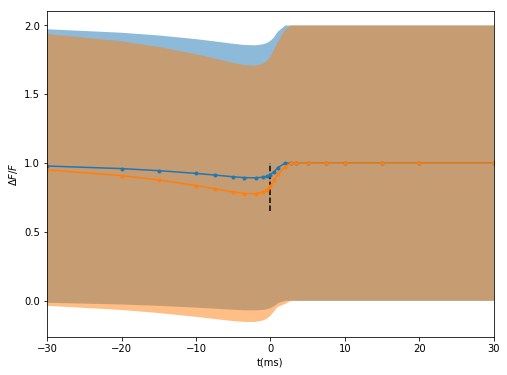

In [43]:
figure(figsize=(8,6))
#me2 = 1.0*medata2
sel = mes[:,0].argsort()
plot(tdels,data2[:,0],'.-',label=int(mes[0,-1]))
fill_between(tdels,data2[:,0]+data2[:,0+4],data2[:,0]-data2[:,0+4],alpha=0.5)

plot(tdels,data2[:,3],'.-',label=int(mes[0,-1]))
fill_between(tdels,data2[:,3]+data2[:,3+4],data2[:,3]-data2[:,3+4],alpha=0.5)

xlabel("t(ms)")
ylabel("$\Delta F/ F$")
xlim(-30,30)
#legend(title="$n_{GABAR}$")
vlines(0.0,0.65,1.0,linestyle="--")
#savefig("CEItiming.png",bbox_inches='tight',pad_inches = 0)

## Baseline conditions

In [36]:
sps = btset_cd(cd='Sp',size=nsp)
sps['A2'][isnan(sps['A2'])] = 0.0
sps['Rneck']=  sps['Rneck']*2

In [45]:
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,sps,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
with open("../SpineModel/dis_baselineB_spsx2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3],f) 
    
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
with open("../SpineModel/dis_baselineB_disx2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3],f) 

In [46]:
td = 10
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_glu_ga10x2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    
td = -10
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_ga_glu10x2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
      
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_baselinex2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 

In [47]:
td = 5
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_glu_ga05x2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    
td = -5
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_ga_glu05x2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    

In [48]:
#vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa*0)


In [49]:
#td = 500
#vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,sps,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
#with open("../SpineModel/dis_baselineB_sps.pickle","wb") as f:
#    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3],f) 
#    
#vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
#with open("../SpineModel/dis_baselineB_dis.pickle","wb") as f:
#    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3],f) 

In [37]:
from bootstrap import dataset
with open("data_Fullset/Fullset.pkl","rb") as f:
    data = pickle.load(f)
spdata = dataset(data,noise=0.0)
spdata['A2'][isnan(spdata['A2'])] = 0.0
#spdata['A1'][isnan(spdata['A1'])] = 0.0 
spdata['Rneck'] = 2*spdata['Rneck']

In [38]:
sel = ones(spdata['A2'].shape[0]) == 1
#print(sel.sum())
keys = list(spdata.keys())
keys.pop(12)
keys.pop(11)
keys.pop(7)
keys.pop(3)
#keys.pop(26)

for key in keys:
    sel = sel*isfinite(spdata[key])
    #print(key,':',sel.sum())
    
for key in spdata.keys():
    spdata[key] = spdata[key][sel]
    print(key,':',isfinite(spdata[key]).sum())

#Bch : 365
Dsb : 365
Dss : 365
d_interSp : 357
Vtot : 365
Vh : 365
Ln : 365
SA : 365
nPSD : 365
A1 : 365
A2 : 365
GPHN SNR : 40
DiS-EMchk : 27
Lneck : 365
maxDneck : 365
minDneck : 365
meanDneck : 365
Rneck : 365
Lhead : 365
maxDhead : 365
minDhead : 365
meanDhead : 365
Ah : 365
Rhead : 365
L : 365
D : 365
AhA0 : 365


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [52]:
spdata['Rneck'].mean()

171.50774922258847

In [53]:
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
with open("../SpineModel/All_baseline_datasetx2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,spdata],f) 
 

In [54]:
dendp2 = dendN
dendp1 = dendc

In [110]:
td = 500

vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
   
td = -2
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_ga_glu02x2.pickle","wb") as f:
    pickle.dump([dis,mes,mes0],f) 

td = 2
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

vtt = clip(vtracs0-EL0,0,100)
if times_biexp:
    times0 = get_atimes(vtt,ton=3000, dt = lb.h.dt)
else:
    times0, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

vtt = clip(vtracs-EL0,0,100)
if times_biexp:
    times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
else:
    times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

with open("../SpineModel/dis_glu_ga02x2.pickle","wb") as f:
    pickle.dump([dis,mes,mes0,times,times0],f) 
    
    

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


## EPSP in soma as a function of the distance - Dend integration


In [55]:
td = 500
mVs = zeros((nsp*200,5))
for i in range(200):
    sps = btset_cd(cd='Sp',size=nsp)
    sel = isnan(sps['A2'])
    sps['A2'][sel] = 0.0
    sps['Rneck'] = sps['Rneck']*2
    
    dendsizeL = max(max(sps['Dss'])+10,177)
    dendp1.L = dendsizeL-10
    dendp2.L = 8 
    dendsh.L = 2    
    
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,sps,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
    mVs[(i*nsp):((i+1)*nsp),:3] = mes[:,1:4]
    mVs[(i*nsp):((i+1)*nsp),3] = 2.0-sel*1.0
    mVs[(i*nsp):((i+1)*nsp),4] = sps['Dss']
    if i%10==0:
        print(i)
        with open("../SpineModel/SPS_Voltagedistx1e5_tempx2.pickle","wb") as f:
            pickle.dump(mVs[:((i+1)*500),:],f) 
        
with open("../SpineModel/SPS_Voltagedistx1e5x2.pickle","wb") as f:
    pickle.dump(mVs,f) 
 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [39]:
me = gtrA*spdata['A1'].mean()*1e3
gtrA = gtrA/me*0.5

In [41]:
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_baselinex2_gtrAo2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 

In [70]:


td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
with open("../SpineModel/All_baseline_datasetx2_gtrAo2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,spdata],f) 
 
td = 5
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_glu_ga05x2_gtrAo2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    
td = -5
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_ga_glu05x2_gtrAo2.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    

In [40]:
tdels = [-49,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50]
dtime = zeros((len(tdels),15))
data = zeros((len(tdels),20))
data2 = zeros((len(tdels),20))

times_biexp = False

EL0 = -70
vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

vtt = clip(vtracs0-EL0,0,100)
if times_biexp:
    times0 = get_atimes(vtt,ton=3000, dt = lb.h.dt)
else:
    times0, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)


for i,td in enumerate(tdels):
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
    
    # EPSP in spine head
    vtt = clip(vtracs-EL0,0,100)
    if times_biexp:
        times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    else:
        times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
        times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

    #dtime[i,:2] = (times.mean(),times.std())
    dtime[i,:5] = getint(times/times0)
    #dtime[i,2:6] = (tt.mean(),tt.std(),trise.mean(),trise.std())

    # EPSP In the soma
    vtt = clip(vtracsS-EL0,0,100)
    if times_biexp:
        times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    else:
        times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
        times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

    #dtime[i,6:8] = (times.mean(),times.std())
    dtime[i,5:10] = getint(times/times0)
    
    # For calcium in spine
    vtt = clip(Ctracs,0,100)
    if times_biexp:
        times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    else:
        times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
        times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    #dtime[i,8:10] = (times.mean(),times.std())
    dtime[i,10:15] = getint(times/times0)
    
    # Statistics
    #data[i,:] = mes.mean(axis=0)
    #datt0 = mes[:,1:5]/mes0[:,1:5]
    #data2[i,:] = concatenate((datt0.mean(axis=0),datt0.std(axis=0)))
    for j in range(1,5):
        data[i,(5*(j-1)):(5*(j))] = getint(mes[:,j])
        data2[i,(5*(j-1)):(5*(j))] = getint(mes[:,j]/mes0[:,j])
        
with open("inhibition_disx2_gtrAo2.pickle","wb") as f:
    pickle.dump([tdels,data2,data,dtime],f)

In [71]:
td = 500

vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
   
td = -2
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open("../SpineModel/dis_ga_glu02x2_gtrAo2.pickle","wb") as f:
    pickle.dump([dis,mes,mes0],f) 

td = 2
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

vtt = clip(vtracs0-EL0,0,100)
if times_biexp:
    times0 = get_atimes(vtt,ton=3000, dt = lb.h.dt)
else:
    times0, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

vtt = clip(vtracs-EL0,0,100)
if times_biexp:
    times = get_atimes(vtt,ton=3000, dt = lb.h.dt)
else:
    times, tt, trise = get_atimes(vtt,ton=3000, dt = lb.h.dt)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

with open("../SpineModel/dis_glu_ga02x2_gtrAo2.pickle","wb") as f:
    pickle.dump([dis,mes,mes0,times,times0],f) 
    
    

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
Rneck0 = spdata['Rneck']*1.0

In [77]:
temp = []
for factor in [0.05,0.1,0.5,1.0,2.0,5.0,10.0]:
    spdata['Rneck'] = Rneck0*factor
    td = 500
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
    temp.append([factor*500,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean()])
    print(factor*500,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean())

25.0 1.2142088744062844 0.8733895847511165 0.8346346141452502
50.0 1.2106899193411416 0.8723165870846131 0.8286156871048693
250.0 1.1863534928403556 0.8635672077834163 0.7953733434723987
500.0 1.1601805507704432 0.8565195163242053 0.7689554414274593
1000.0 1.115912761031422 0.8483175000966556 0.7254464153755171
2500.0 1.0167768585961163 0.8388198644354843 0.6301728056915725
5000.0 0.9046950736756618 0.8376806830200179 0.5347454222549043


In [81]:
spdata['Rneck'] = Rneck0*1.0

In [86]:
dendsizeL = max(max(sps['Dss'])+10,177)
dendp1.L = dendsizeL-10
dendp2.L = 8 
dendsh.L = 2    
    

In [87]:
for dend in model.dend:
    print(dend.hname(),dend.diam,dend.L)

dendA1c 1.0 10.0
dendA1 0.6999999880790713 167.0
dendB1 1.5 50.15974481593781
DendE 0.7 2.0
DendN 10.0 8.0


In [47]:
dendB1 = model.dend[2]
print(dendB1.cm)

1.0


In [48]:
temp = []
for factor in [0.05,0.1,0.5,1.0,2.0,5.0,10.0]:
    dendB1.cm = 3.5*factor
    dendB1.g_pas = 3.5*factor/model.RM
    #spdata['Rneck'] = Rneck0*factor
    td = 500
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
    temp.append([factor,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean()])
    print(factor,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean())


0.05 2.0649810254059364 0.7960003619779398 0.6539087957275653
0.1 2.0327403410020626 0.7961355790115334 0.6539571525849875
0.5 1.8094665823508589 0.7970401806183547 0.6542492563972206
1.0 1.5960604098739362 0.7978433486611755 0.6544678970140368
2.0 1.3032275650727654 0.7988633451933811 0.6546959525482141
5.0 0.8821468496505699 0.8001753853749773 0.6549266357022808
10.0 0.63366058807267 0.8009551194942227 0.6550304633475776


In [40]:
temp = []
for factor in [0.05,0.1,0.5,1.0,2.0,5.0,10.0]:
    dendN.cm = 3.5*factor
    dendc.cm = 3.5*factor

    dendN.g_pas = 3.5*factor/model.RM
    dendc.g_pas = 3.5*factor/model.RM
    #spdata['Rneck'] = Rneck0*factor
    td = 500
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
    temp.append([factor,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean()])
    print(factor,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean())


0.05 3.8913193170011433 0.6490362171131004 0.552802338508385
0.1 3.7076657780054583 0.660290179389763 0.570430553218131
0.5 2.6153829598439944 0.7338406453484134 0.6274419477468431
1.0 1.9219749535542898 0.7965929399720055 0.6541112676761313
2.0 1.287415400264035 0.8954531387849516 0.6868236028663914
5.0 0.6424301208134424 1.0973979752845977 0.7377440401819891
10.0 0.32167860413694915 1.3199508451308781 0.7785583093994025


In [41]:
dendN.hname(),dendc.hname()

('DendN', 'dendA1')

In [42]:
dendN.cm = 3.5
dendc.cm = 3.5

dendN.g_pas = 3.5/model.RM
dendc.g_pas = 3.5/model.RM

In [46]:
temp = []
for factor in [0.05,0.1,0.5,1.0,2.0,5.0,10.0]:
    dendN.Ra = 250*factor
    dendc.Ra = 250*factor
    #spdata['Rneck'] = Rneck0*factor
    td = 500
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
    temp.append([factor,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean()])
    print(factor,mes[:,3].mean(),mes[:,3].std()/mes[:,3].mean(),mes[:,1].std()/mes[:,1].mean())
dendN.Ra = 250
dendc.Ra = 250

0.05 3.2648595003909273 0.8230360559868927 0.7725066838044191
0.1 3.1476873248467276 0.8161435960996779 0.7560481465739917
0.5 2.4314777898518276 0.7920454586740884 0.6907432275078711
1.0 1.9219749535542898 0.7965929399720055 0.6541112676761313
2.0 1.390444414843422 0.8345272441317572 0.6159411572808725
5.0 0.7712067827030364 0.9627645397666658 0.5625521715826524
10.0 0.4232897231499208 1.1487071868286383 0.5179715044153325


In [45]:
dendN.Ra

250.0

In [38]:
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)


In [71]:
sel = (spdata['Vh']<.05)*(spdata['Dss']>0.)*(spdata['Dss']<200)
print(sel.sum())
mes[sel,3].std()/mes[sel,3].mean(),spdata['A1'][sel].std()/spdata['A1'][sel].mean()

161


(0.5520828183309516, 0.5339123348063345)

Text(0, 0.5, 'Volume Head (um3)')

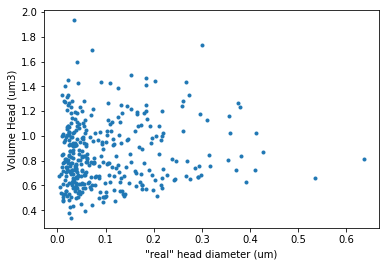

In [78]:
plot(spdata['Vh'],column_stack((spdata['Lhead'],spdata['maxDhead']/1000)).max(1),'.')
xlabel(' "real" head diameter (um) ')
ylabel('Volume Head (um3)')

Text(0, 0.5, 'Volume Head (um3)')

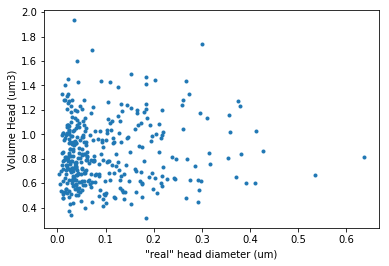

In [83]:
plot(spdata['Vh'],spdata['Lhead'],'.')
xlabel(' "real" head diameter (um) ')
ylabel('Volume Head (um3)')

Text(0, 0.5, 'Volume Head (um3)')

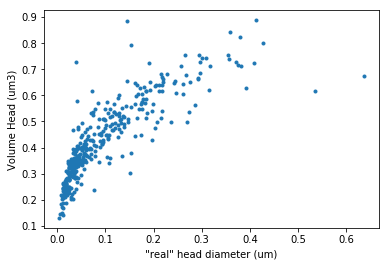

In [89]:
plot(spdata['Vh'],(spdata['maxDhead']/1000),'.')
xlabel(' "real" head diameter (um) ')
ylabel('Volume Head (um3)')

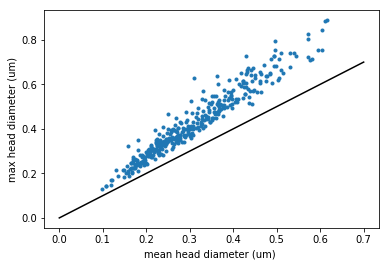

In [95]:
plot((spdata['meanDhead']/1000),(spdata['maxDhead']/1000),'.')
xlabel('mean head diameter (um) ')
ylabel('max head diameter (um)')
plot(linspace(0.,0.7),linspace(0.,0.7),'k')

Text(0, 0.5, 'Area Head (um3)')

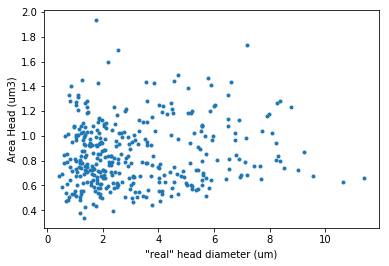

In [79]:
plot(spdata['Ah'],column_stack((spdata['Lhead'],spdata['maxDhead']/1000)).max(1),'.')
xlabel(' "real" head diameter (um) ')
ylabel('Area Head (um3)')

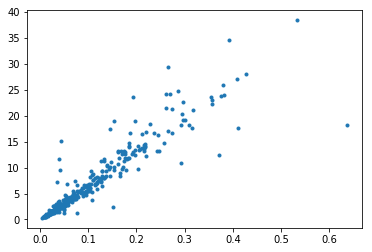

In [77]:

plot(spdata['Vh'],spdata['Ah']**(3./2.),'.')

(array([ 8., 34., 45., 29., 24., 13.,  6.,  1.,  0.,  1.]),
 array([0.33830983, 0.49784224, 0.65737465, 0.81690707, 0.97643948,
        1.13597189, 1.2955043 , 1.45503672, 1.61456913, 1.77410154,
        1.93363395]),
 <a list of 10 Patch objects>)

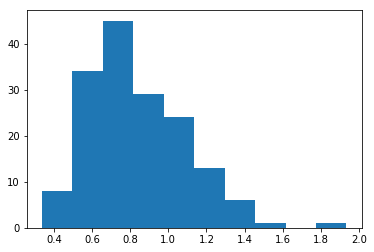

In [72]:
hist(column_stack((spdata['Lhead'],spdata['maxDhead']/1000)).max(1)[sel])

(array([ 1.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,  4.,  2.,  7.,  8.,  6.,
         7.,  5.,  9., 10., 10.,  7.,  6., 12., 15.,  7., 11., 11.,  8.,
         8., 12., 10.,  8.,  6., 10.,  6.,  3.,  5.,  1.,  9., 10.,  6.,
         7.,  8.,  6.,  8.,  9.,  4.,  3.,  8.,  4.,  4.,  4.,  2.,  2.,
         5.,  5.,  3.,  3.,  5.,  3.,  5.,  2.,  0.,  1.,  3.,  0.,  0.,
         1.,  1.,  1.,  4.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.33830983, 0.35426307, 0.37021631, 0.38616955, 0.40212279,
        0.41807604, 0.43402928, 0.44998252, 0.46593576, 0.481889  ,
        0.49784224, 0.51379548, 0.52974872, 0.54570197, 0.56165521,
        0.57760845, 0.59356169, 0.60951493, 0.62546817, 0.64142141,
        0.65737465, 0.6733279 , 0.68928114, 0.70523438, 0.72118762,
        0.73714086, 0.7530941 , 0.76904734, 0.78500058, 0.80095383,
        0.81690707, 0.8328

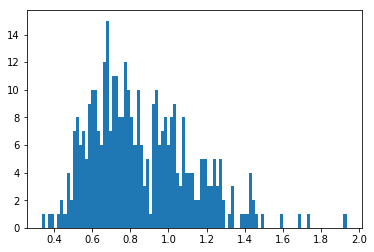

In [56]:
hist(column_stack((spdata['Lhead'],spdata['maxDhead']/1000)).max(1),100)

(array([27., 57., 56., 34., 24., 19.,  9., 16., 14., 12., 10.,  8.,  7.,
        10.,  9.,  6.,  9.,  3.,  2.,  2.,  6.,  2.,  4.,  3.,  3.,  0.,
         0.,  3.,  0.,  4.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00399359, 0.01664214, 0.02929069, 0.04193925, 0.0545878 ,
        0.06723636, 0.07988491, 0.09253347, 0.10518202, 0.11783058,
        0.13047913, 0.14312769, 0.15577624, 0.1684248 , 0.18107335,
        0.19372191, 0.20637046, 0.21901901, 0.23166757, 0.24431612,
        0.25696468, 0.26961323, 0.28226179, 0.29491034, 0.3075589 ,
        0.32020745, 0.33285601, 0.34550456, 0.35815312, 0.37080167,
        0.38345022, 0.39609878, 0.40874733, 0.42139589, 0.43404444,
        0.446693  , 0.45934155, 0.47199011, 0.48463866, 0.49728722,
        0.50993577, 0.52258433, 0.53523288, 0.54788144, 0.56052999,
        0.57317854, 0.5858271 , 0.59847565, 0.61112421, 0.62377276,
        0.63642132]),
 <a list of 50

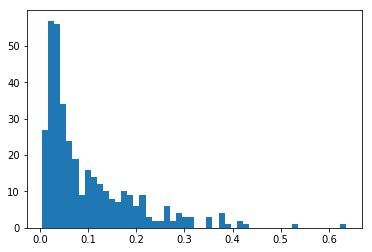

In [84]:
hist(spdata['Vh'],50)

(array([ 1.,  2.,  1.,  0.,  0.,  2.,  1.,  2.,  0.,  3.,  3.,  4.,  5.,
         5.,  5.,  8.,  6.,  6.,  2.,  7.,  7.,  6.,  7.,  9.,  3.,  9.,
         9., 13.,  9., 10.,  9.,  8.,  7.,  5.,  9., 10.,  5.,  5.,  4.,
         7.,  3.,  6.,  5.,  3.,  3.,  9.,  4.,  3.,  6.,  3.,  7.,  5.,
         5.,  6.,  1.,  7.,  1.,  7.,  3.,  1.,  3.,  1.,  4.,  2.,  7.,
         3.,  1.,  5.,  5.,  2.,  3.,  2.,  3.,  1.,  0.,  0.,  3.,  1.,
         5.,  0.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([0.13040497, 0.13798081, 0.14555665, 0.15313249, 0.16070833,
        0.16828417, 0.17586001, 0.18343585, 0.19101168, 0.19858752,
        0.20616336, 0.2137392 , 0.22131504, 0.22889088, 0.23646672,
        0.24404256, 0.2516184 , 0.25919424, 0.26677008, 0.27434592,
        0.28192176, 0.2894976 , 0.29707344, 0.30464928, 0.31222512,
        0.31980096, 0.3273768 , 0.33495264, 0.34252847, 0.35010431,
        0.35768015, 0.3652

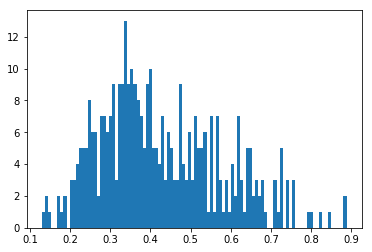

In [85]:
hist(spdata['maxDhead']/1000,100)